In [1]:
import misc
from plots import *

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from logparser import LogReader, PosReader

# Prepare the data

In [2]:
# Load log files
logs = []

logs.append(misc.getLogDictionnary(
    "Google Pixel 7",
    "../.data/2023_Dataset_Hervanta/1_static/Google_Pixel7/gnss_log_2023_02_17_09_55_01.txt",
    "logger"
))

logs.append(misc.getLogDictionnary(
    "OnePlus Nord 2",
    "../.data/2023_Dataset_Hervanta/1_static/OnePlus_Nord2/gnss_log_2023_03_03_10_55_04.txt",
    "logger"
))

logs.append(misc.getLogDictionnary(
    "Samsung A52",
    "../.data/2023_Dataset_Hervanta/1_static/Samsung_A52/gnss_log_2023_03_17_14_12_30.txt",
    "logger"
))

logs.append(misc.getLogDictionnary(
    "Xiaomi 11T",
    "../.data/2023_Dataset_Hervanta/1_static/Xiaomi_11T/gnss_log_2023_03_03_09_56_06.txt",
    "logger"
))

# Parse log - This might take a while...
for log in logs:
    log['content'] = LogReader(log['filepath'], ['Raw', 'Fix'])

In [3]:
# Set reference position
# filepath = "../example_data/NMND17420010S_2023-08-01_08-24-35.pos"
# ref = PosReader(filepath)

In [4]:
# Compute ENU errors
ref_enu = [61.44922404, 23.8562781, 162.711]
for log in logs:
    log['content'].fix[["east", "north", "up"]] = log['content'].fix.apply(
        lambda row: misc.convert2ENU(row['latitude'], row['longitude'], row['altitude'], ref_enu), 
        axis='columns', result_type='expand')
    
    log['content'].fix[["2D_error"]] = log['content'].fix.apply(
        lambda row: misc.getHorizontalError(row['east'], row['north']), 
        axis='columns', result_type='expand')
    
    log['content'].fix[["3D_error"]] = log['content'].fix.apply(
        lambda row: misc.get3DError(row['east'], row['north'], row['up']), 
        axis='columns', result_type='expand')

# Results

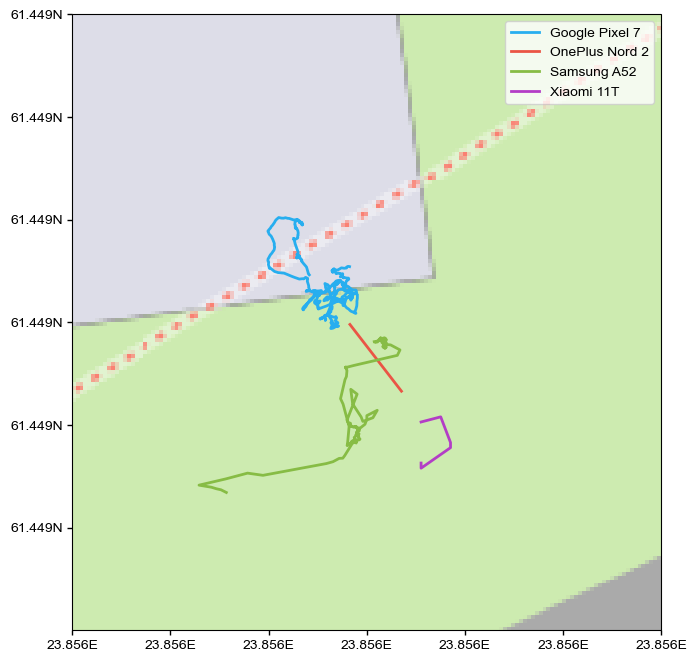

In [7]:
center = ref_enu[:2]
#extent = [center[1] - 0.02, center[1] + 0.005, center[0] - 0.005, center[0] + 0.005]
extent = [center[1] - 0.0002, center[1] + 0.0002, center[0] - 0.0001, center[0] + 0.0001]

locations = {}
for log in logs:
    locations[log['device_name']] = log['content'].fix.loc[log['content'].fix['provider'].isin(['GPS']), ["latitude", "longitude"]]

plotMap(locations=locations, extent=extent, scale=19)

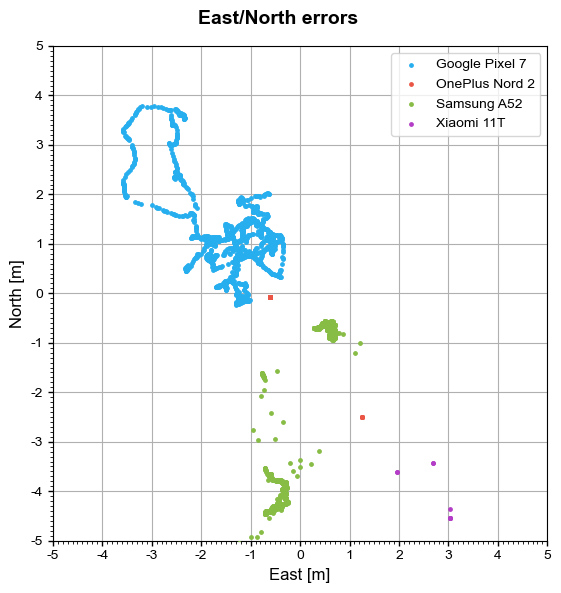

In [6]:
plotEN(logs, lim=5, ticks=[0.1, 1])